### Analyze ISM for HPC glia

We did the ISM for exons with deltaPSI > 0.1 between neurons and glia. These scores can be downloaded from Zenodo.

In [1]:
import numpy as np
import pandas as pd
import h5py

import seaborn as sns
from matplotlib import pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42


First, we load the results of the ISM

In [2]:
datadir = '../../Zenodo/Human/HPC/DL_ISM/'

genes = np.load(datadir+'/genes.npz')
genes = np.array(genes['arr_0'], dtype='<U50')

ism = np.load(datadir+'/ism.npz')
ism = ism['arr_0']
ism = np.asarray(ism, dtype=float)

ref = np.load(datadir+'/ref.npz')
ref = ref['arr_0']

seq = np.load(datadir+'/seq.npz')
seq = seq['arr_0']

spl = np.load(datadir+'/splice.npz')
spl = spl['arr_0']



For Figure 4A, we look at the mean effect of the mutations. For that, we have to know where the exons start and end. The one-hot encoded input track for this is stored in 'spl'.

In [3]:
exon_str = np.where(spl)[1][::2]
exon_end = np.where(spl)[1][1::2]

The dimensions of ism is exons x nucleotides x positions. Here, we take the maximum score over the four nucleotides.

In [4]:
ism_abs = np.max(np.abs(ism), axis=1)
print(np.shape(ism))
print(np.shape(ism_abs))

(9929, 4, 6144)
(9929, 6144)


Now, are loop over all the exons to calculate the average score before, within, and after the exon. Since all exons have different lengths, we bin these scores.

In [5]:
bfr = np.zeros((3077,))
aft = np.zeros((3077,))
exn = np.zeros((1529,))

for i in range(len(ism)):
    bfr_i = np.flip(ism_abs[i,:exon_str[i]])
    bins = np.linspace(0, len(bfr_i)-1, num=3077, dtype=int)
    bfr += bfr_i[bins]/len(ism)
    
    aft_i = ism_abs[i, exon_end[i]:]
    bins = np.linspace(0, len(aft_i)-1, num=3077, dtype=int)
    aft += aft_i[bins]/len(ism)
    
    exn_i = ism_abs[i,exon_str[i]:exon_end[i]]
    exn_len = exon_end[i] - exon_str[i]
    bins = np.linspace(0,exn_len-1,num=1529, dtype=int)
    exn += exn_i[bins]/len(ism)

Concatenate the results from before, exon, and after. We bin the exon to 300 bp now.

In [6]:
len_exon = 300
y = np.concatenate((np.flip(bfr), exn, aft))
x = np.concatenate((np.linspace(0,3076,num=3077), np.linspace(0,len_exon,num=1529)+3077, np.linspace(1,3077,num=3077)+3077+len_exon))

#### Figure 3A

We add grey lines to the plot, so we know where to draw the exon using illustrator later on. 

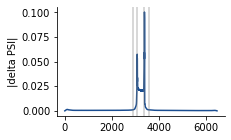

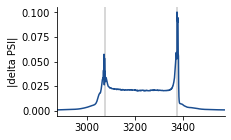

In [7]:
plt.figure(figsize=(3,2))
sns.lineplot(x=x, y=y, color='#1B4E91')
plt.axvline(3076-200, c='grey', alpha=0.4)
plt.axvline(3076+len_exon+200, c='grey', alpha=0.4)
plt.axvline(3076, c='grey', alpha=0.4)
plt.axvline(3076+len_exon, c='grey', alpha=0.4)
sns.despine()
plt.ylabel('|delta PSI|')
plt.show()

plt.figure(figsize=(3,2))
plt.axvline(3076, c='grey', alpha=0.4)
plt.axvline(3076+len_exon, c='grey', alpha=0.4)
sns.lineplot(x=x, y=y, color='#1B4E91')
plt.xlim([3076-200,3076+len_exon+200])
sns.despine()
plt.ylabel('|delta PSI|')
plt.show()

#### Figure S15

We will do the same, but now look at the maximum instead of the average

In [8]:
bfr_all = np.zeros((3077,len(ism)))
aft_all = np.zeros((3077,len(ism)))
exn_all = np.zeros((1529,len(ism)))

for i in range(len(ism)):
    bfr_i = np.flip(ism_abs[i,:exon_str[i]])
    bins = np.linspace(0, len(bfr_i)-1, num=3077, dtype=int)
    bfr_all[:,i] = bfr_i[bins]
    
    aft_i = ism_abs[i, exon_end[i]:]
    bins = np.linspace(0, len(aft_i)-1, num=3077, dtype=int)
    aft_all[:,i] = aft_i[bins]
    
    exn_i = ism_abs[i,exon_str[i]:exon_end[i]]
    exn_len = exon_end[i] - exon_str[i]
    bins = np.linspace(0,exn_len-1,num=1529, dtype=int)
    exn_all[:,i] = exn_i[bins]

In [9]:
len_exon = 300
y_max = np.concatenate((np.flip(np.max(bfr_all, axis=1)), np.max(exn_all, axis=1), np.max(aft_all, axis=1)))
x_max = np.concatenate((np.linspace(0,3076,num=3077), 
                        np.linspace(0,len_exon,num=1529)+3077, 
                        np.linspace(1,3077,num=3077)+3077+len_exon))

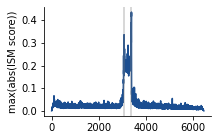

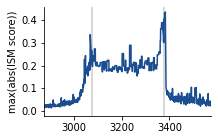

In [10]:
plt.figure(figsize=(3,2))
sns.lineplot(x=x_max, y=y_max, color='#1B4E91')
plt.axvline(3076, c='grey', alpha=0.4)
plt.axvline(3076+len_exon, c='grey', alpha=0.4)
sns.despine()
plt.ylabel('max(abs(ISM score))')
plt.show()

plt.figure(figsize=(3,2))
plt.axvline(3076, c='grey', alpha=0.4)
plt.axvline(3076+len_exon, c='grey', alpha=0.4)
sns.lineplot(x=x_max, y=y_max, color='#1B4E91')
plt.xlim([3076-200,3076+len_exon+200])
sns.despine()
plt.ylabel('max(abs(ISM score))')
plt.show()

### Plotting ISM binding scores per exon

Besides summarizing the results, we can also plot the ISM scores per exon. Here, we show two examples for Figure 4B and D, but this can be applied to any exon

#### Figure 4B

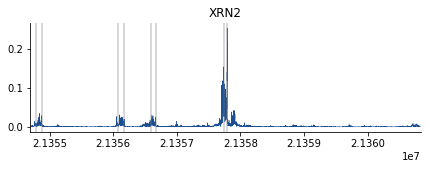

In [13]:
plt.figure(figsize=(7,2))

i = np.where(genes == 'chr20_21357736_21357792_ENSG00000088930_+')[0][0]

sns.lineplot(x=np.linspace(21354692,21360835,num=6144, dtype=int),
                y=ism_abs[i], color='#1B4E91', linewidth=0.5)

# We found these coordinates in the GTF file
# Exon of interest
plt.axvline(21357736, c='grey', alpha=0.4)
plt.axvline(21357792, c='grey', alpha=0.4)

# Neighbor 1
plt.axvline(21354789, c='grey', alpha=0.4)
plt.axvline(21354872, c='grey', alpha=0.4)

# Neighbor 2
plt.axvline(21356080, c='grey', alpha=0.4)
plt.axvline(21356177, c='grey', alpha=0.4)

# Neighbor 3
plt.axvline(21356586, c='grey', alpha=0.4)
plt.axvline(21356665, c='grey', alpha=0.4)

plt.title('XRN2')
sns.despine()
plt.xlim([21354692,21360835])
plt.show()


#### Figure 4D

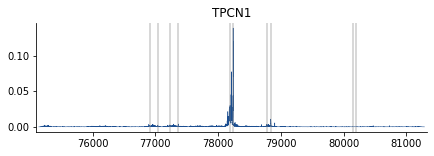

In [14]:
plt.figure(figsize=(7,2))

i = 124

sns.lineplot(x=np.linspace(75143,81286,num=6144, dtype=int),
                y=ism_abs[i], color='#1B4E91', linewidth=0.5)

## These lines indicate other exons found in the GTF file
plt.axvline(78189, c='grey', alpha=0.4)
plt.axvline(78237, c='grey', alpha=0.4)
plt.axvline(76918, c='grey', alpha=0.4)
plt.axvline(77035, c='grey', alpha=0.4)
plt.axvline(77239, c='grey', alpha=0.4)
plt.axvline(77364, c='grey', alpha=0.4)
plt.axvline(78772, c='grey', alpha=0.4)
plt.axvline(78835, c='grey', alpha=0.4)
plt.axvline(80151, c='grey', alpha=0.4)
plt.axvline(80195, c='grey', alpha=0.4)
plt.title('TPCN1')
sns.despine()
plt.xlim([75103,81326])
plt.show()


Zoom and visualize sequence + effect mutations

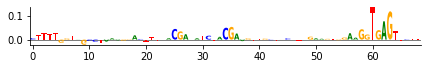

In [15]:
import logomaker

i = 124
begin = 3046-10
end = 3095+10

fig = plt.figure(figsize=(7,0.7))
ax = fig.add_subplot(111) 

df = pd.DataFrame(np.multiply(ism[i][:,begin:end], seq[i][:,begin:end]), index=['A', 'C', 'G', 'T']).T
df.index.name = 'pos'

crp_logo = logomaker.Logo(df, ax=ax)
sns.despine()
plt.show()

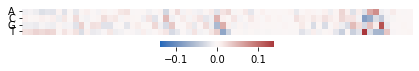

In [28]:
plt.figure(figsize=(7,0.7))
sns.heatmap(ism[i][:,begin:end], cmap='vlag', center=0,
           vmin=-0.14, vmax=0.14, 
            cbar_kws=dict(orientation='horizontal'))
plt.yticks([0.4,1.4,2.4,3.4], ['A','C','G','T'], rotation=0)
plt.xticks([])
plt.show()